In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# to process image data, we use fastai.vision
from fastai.vision.all import * 
# This is the latest point where we really should use the GPU for computing. 
# We first test, if there is a CUDA device available
print( torch.cuda.get_device_name(0) )
print( torch.__version__ )

NVIDIA GeForce RTX 3070
2.3.0+cu121


In [3]:
# Fix random seed -> pseudo random 
torch.manual_seed(0) # for pyTorch
random.seed(0)       # for python

## Load Data

In [4]:
from pathlib import Path
import os

# First, we create a path-object that points to the data
path = Path('data/mnist_png/')
sub_directories = [f.path for f in os.scandir(path) if f.is_dir()]
     
image_files = get_image_files(path)
image_files

# Now we define a function that creates a label for each filename. In our case,
# the class is encoded in the directory name. To create the label function,
# we typically have to check the directory structure and the structure of the filenames.
def label_function(filename):
    return filename.parents[0].name

When loading the images, we can pass transfomations to change the images (for example adapt the size) and realize data augmentations. In our case the images already have the appropriate size (64x64 pixels), but we use severeal data augmentations to improve generalization. Also, we normalize the images to the statistics from ImageNet.

In [5]:
item_transforms  = []

# If images need to be cropped in size, this can be done as follows:
# A drawback of the vgg16 is the fixed input size of $244\times244$ pixels. 
item_transforms = []
batch_transforms = [*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]

We create a random spliter object to split data data in training- and validation data. Test data is split on file level.

In [6]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)

Now we create a DataBlock. Hereby, we specify first which "Blocks", i.e. types of encoding, we want to use. In our case we need an ImageBlock for the input and a CategoryBlock for the output.

In [7]:
blocks = (ImageBlock, CategoryBlock)

block = DataBlock(blocks=blocks,
                  get_items=get_image_files,
                  get_y=label_function,
                  splitter=splitter,
                  item_tfms=item_transforms,
                  batch_tfms=batch_transforms)

In [8]:
batchSize = 32
data_loader = block.dataloaders(path, bs=batchSize, num_workers=0)

To check the impact of the transformations, we can repeatedly executre the cell below. Every run creates new, transformed, images.

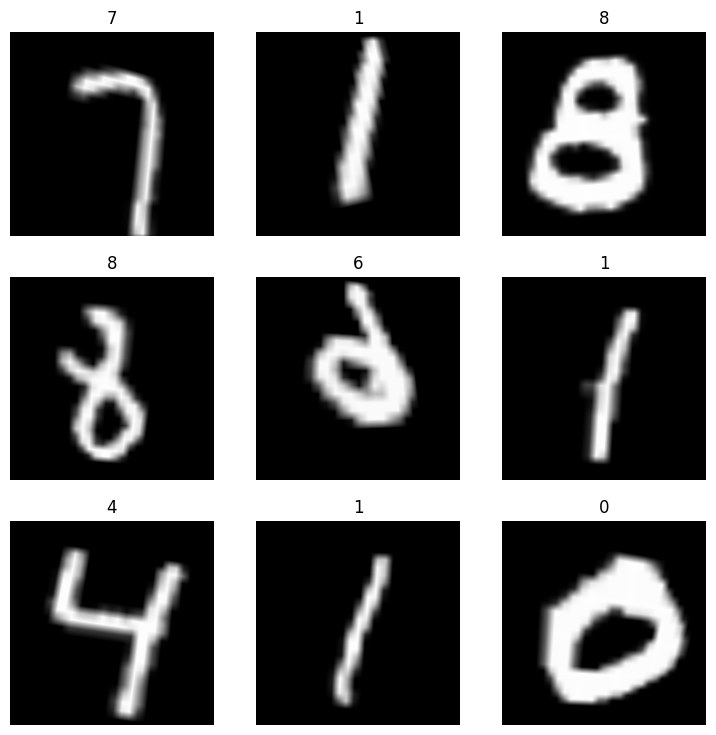

In [9]:
data_loader.show_batch()

## Training: VGG16

Now we know how our data looks and are convinced, that the loading of both images and labels, as well as the transformations, work as intended. It is time to train a first model. You can experiment with different architectures and metrics.

In [10]:
architektur = vgg16
metrik = error_rate

Aditional architectures to test are:

* alexnet
* vgg16
* densenet_121 (161, 169, 201)
* resnet18 (34, 50, 101, 152)

Even more architectures are in "torchvision". This can be implemented as follows:

In [11]:
import torchvision.models as torchModels

Additional metrics, that can be tested, include:
* accuracy
* error_rate
* dice

There are more metrics, which cannot be tested with our example:
* mean_squared_error
* mean_absolute_error
* mean_squared_logarithmic_error
* exp_rmspe
* explained_variance
* r2_score

In [12]:
learner = vision_learner(data_loader,
                         architektur,
                         metrics = metrik)

learner.summary()

/home/matthias/Documents/advanced_computer_vision_ss2024_Pijarowski_Matthias/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matthias/Documents/advanced_computer_vision_ss2024_Pijarowski_Matthias/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/matthias/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:18<00:00, 30.3MB/s] 


Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 224 x 224 
Conv2d                                    1792       False     
ReLU                                                           
Conv2d                                    36928      False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 112 x 11 
Conv2d                                    73856      False     
ReLU                                                           
Conv2d                                    147584     False     
ReLU                                                           
___________________________________

The learning rate finder automatically tests different learning rates. Denken Sie daran, den Lerner vorher neu zu erstellen, damit Sie immer mit einer zufälligen Initialisierung der Gewichte starten.
We store the model with the randomly initialized weights for later experiments.

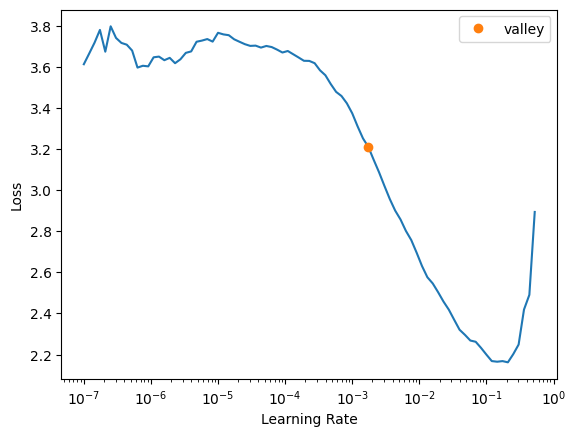

In [13]:
learner.save("vgg16_initial")
learner.lr_find()
gewaehlteLernrate = 1e-03
learner.load("vgg16_initial")

The fit function trains one epoch.

In [14]:
learner.fit( 1, lr=gewaehlteLernrate )

epoch,train_loss,valid_loss,error_rate,time
0,0.318545,0.138317,0.041750,03:37


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

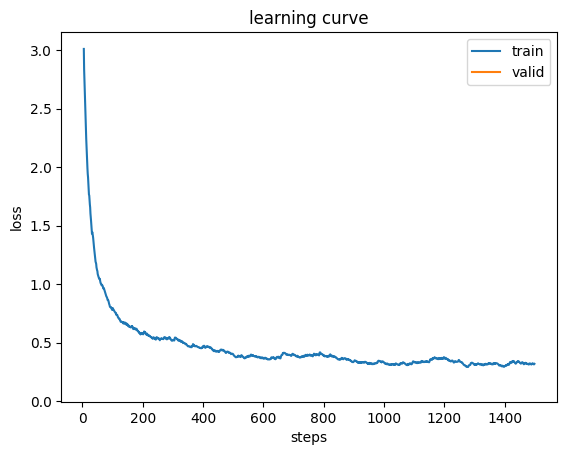

In [15]:
learner.recorder.plot_loss()

In [16]:
learner.save('vgg16_phase1')

Path('models/vgg16_phase1.pth')

## Ergebnisse

We can now examine the models we have learned with regard to the accuracy of the classification. First, we look at which class is most frequently interchanged with which class. Of course, this comparison makes more sense for many classes. In our case with 2 classes, we can only see whether the proportion of swaps is roughly the same.

[('3', '5', 58),
 ('5', '3', 57),
 ('2', '5', 53),
 ('2', '3', 17),
 ('9', '7', 15),
 ('0', '9', 14),
 ('5', '2', 14),
 ('3', '8', 12),
 ('2', '6', 11),
 ('6', '2', 10),
 ('9', '5', 10),
 ('8', '9', 9),
 ('9', '4', 9),
 ('1', '4', 8),
 ('5', '8', 8),
 ('7', '4', 8),
 ('8', '3', 8),
 ('1', '2', 7),
 ('1', '7', 7),
 ('2', '8', 7),
 ('7', '1', 7),
 ('0', '6', 6),
 ('5', '7', 6),
 ('6', '8', 6),
 ('9', '8', 6),
 ('0', '8', 5),
 ('2', '7', 5),
 ('3', '2', 5),
 ('4', '7', 5),
 ('5', '6', 5),
 ('6', '0', 5),
 ('7', '3', 5),
 ('8', '2', 5),
 ('3', '9', 4),
 ('4', '1', 4),
 ('4', '8', 4),
 ('4', '9', 4),
 ('6', '5', 4),
 ('8', '5', 4),
 ('2', '1', 3),
 ('2', '9', 3),
 ('3', '7', 3),
 ('4', '6', 3),
 ('5', '9', 3),
 ('6', '4', 3),
 ('7', '2', 3),
 ('7', '5', 3),
 ('8', '6', 3),
 ('9', '3', 3),
 ('3', '6', 2),
 ('4', '2', 2),
 ('6', '9', 2),
 ('8', '7', 2),
 ('9', '0', 2),
 ('9', '1', 2),
 ('9', '2', 2),
 ('9', '6', 2),
 ('0', '2', 1),
 ('0', '3', 1),
 ('0', '4', 1),
 ('0', '5', 1),
 ('0', '7', 1

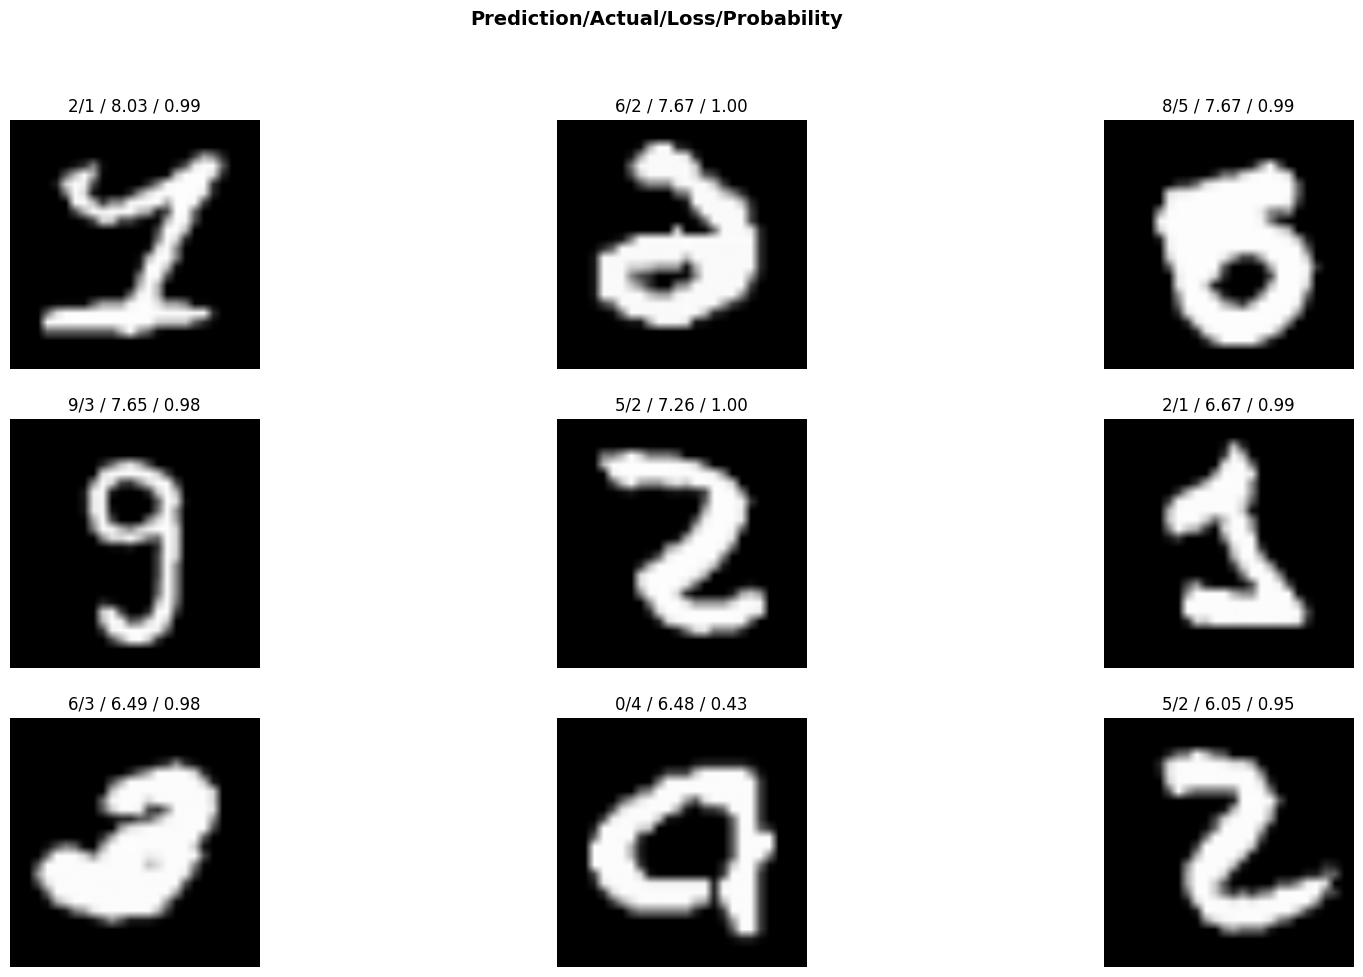

In [17]:
interpretation = ClassificationInterpretation.from_learner(learner)
interpretation.plot_top_losses(9, figsize=(20,11))
interpretation.most_confused(min_val=1)

With the help of a confusion matrix, this can also be easily seen in our simple case.

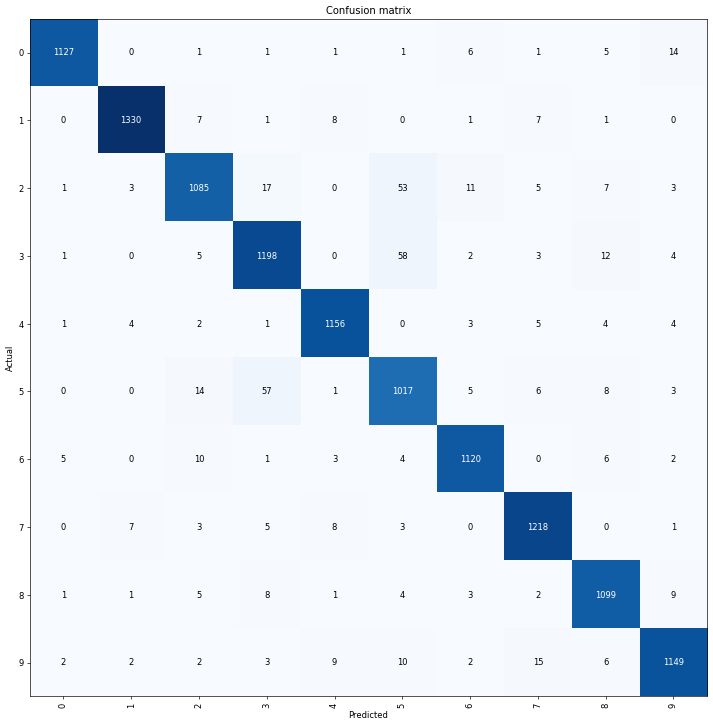

In [18]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
learner = vision_learner(data_loader,
                         torchModels.vgg16,
                         metrics = metrik,
                         init=nn.init.xavier_uniform_)

learner.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 224 x 224 
Conv2d                                    1792       False     
ReLU                                                           
Conv2d                                    36928      False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 112 x 112 
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 112 x 11 
Conv2d                                    73856      False     
ReLU                                                           
Conv2d                                    147584     False     
ReLU                                                           
___________________________________

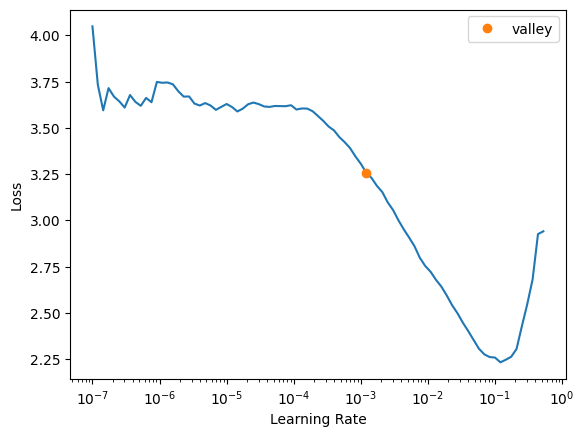

In [25]:
learner.save("vgg16_initial_xavier")
learner.lr_find()
gewaehlteLernrate = 1e-03
learner.load("vgg16_initial_xavier")

epoch,train_loss,valid_loss,error_rate,time
0,0.306055,0.133643,0.040750,03:36


Path('models/vgg16_phase1_xavier.pth')

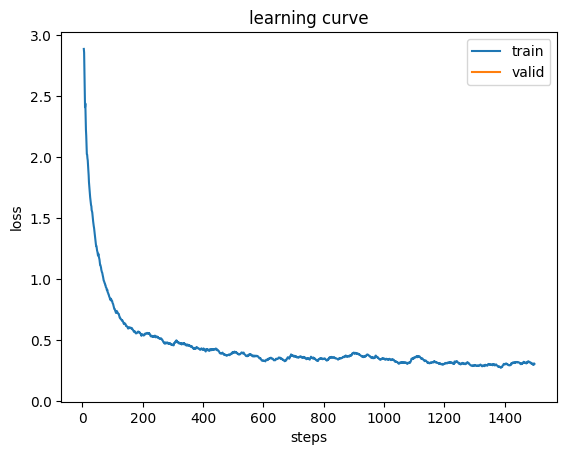

In [26]:
learner.fit( 1, lr=gewaehlteLernrate )

learner.recorder.plot_loss()
learner.save('vgg16_phase1_xavier')

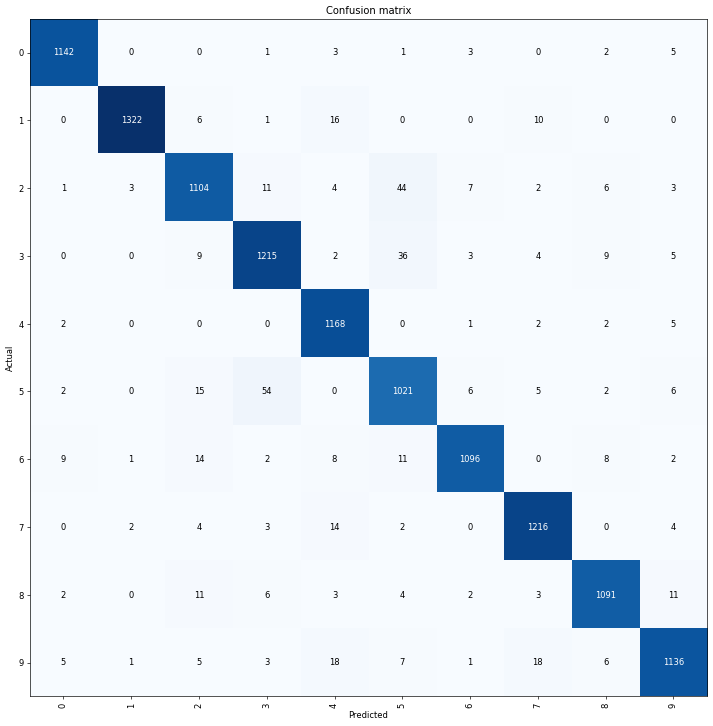

In [27]:
interpretation = ClassificationInterpretation.from_learner(learner)
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [31]:
model = torchModels.vgg16(weights=None)
X = torch.rand((1, 3, 18, 18))
model(X)

RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small